In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom
!pip install segmentation-models-3D
!pip install tensorflow_io
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm_notebook as tqdm
import sys
import glob
import pydicom

from tensorflow.keras.applications import EfficientNetB4
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing
from tensorflow.keras import applications
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import binary_crossentropy
from keras import backend as K


# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm_notebook as tqdm
import sys
import glob2
import cv2
from sklearn.model_selection import train_test_split
import random as rn
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
import pydicom
from keras.preprocessing import image
from matplotlib.pyplot import imread
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.spatial import distance
import segmentation_models_3D as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score , auc
from keras.utils.np_utils import to_categorical
import cv2
import gc
from keras.metrics import MeanIoU
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2 , VGG16 , ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.metrics import MeanIoU
from datetime import date
AUTOTUNE = tf.data.AUTOTUNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 26.1 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [3]:
cd /content/drive/MyDrive/KhoaLuan/DATASET/Train Dataset

/content/drive/MyDrive/KhoaLuan/DATASET/Train Dataset


In [4]:
# Loading the taable which has class and mask information for train images
train_table = pd.read_csv('/content/drive/MyDrive/KhoaLuan/DATASET/Train Dataset/siim/stage_2_train.csv')
train_table.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [5]:
# drop the duplicate ImageIDs
train_table.drop_duplicates(subset ="ImageId", keep = 'first', inplace = True)
train_table.shape

(12047, 2)

In [6]:
# Creating 2 separate directories for train and test dicom images
train_images_dicom = 'siim/train_images_dicom/'
test_images_dicom = 'siim/test_images_dicom/'

if not os.path.isdir(train_images_dicom):
    os.makedirs(train_images_dicom)
if not os.path.isdir(test_images_dicom):
    os.makedirs(test_images_dicom)

In [7]:
# Creating a dataframe containing ImageId, EncodedPixels and ImagePath
train_table['path'] = train_images_dicom + train_table['ImageId']+'.dcm'
train_table.head()

,ImageId,EncodedPixels,path
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,siim/train_images_dicom/1.2.276.0.7230010.3.1....
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,siim/train_images_dicom/1.2.276.0.7230010.3.1....
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,siim/train_images_dicom/1.2.276.0.7230010.3.1....
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,siim/train_images_dicom/1.2.276.0.7230010.3.1....
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,siim/train_images_dicom/1.2.276.0.7230010.3.1....


In [8]:
# Renaming columns for convenience
train_table['mask'] = train_table['EncodedPixels']
train_table = train_table[['path', 'mask']]
train_table.head()

,path,mask
0,siim/train_images_dicom/1.2.276.0.7230010.3.1....,-1
1,siim/train_images_dicom/1.2.276.0.7230010.3.1....,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,siim/train_images_dicom/1.2.276.0.7230010.3.1....,-1
3,siim/train_images_dicom/1.2.276.0.7230010.3.1....,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,siim/train_images_dicom/1.2.276.0.7230010.3.1....,592184 33 976 58 956 73 941 88 926 102 917 109...


In [9]:
test_table = pd.DataFrame(columns = ['path'])
test_data = os.listdir(test_images_dicom)
for file in test_data:
  test_table = test_table.append({'ImageId':file[:-4], 'path':test_images_dicom+file}, ignore_index = True)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
<ipython-input-9-129c6f16d045>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_table = test_table.append({'ImageId':file[:-4], 'path':test_images_dicom+file}, ignore_index = True)
<ipython-input-9-129c6f16d045>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_table = test_table.append({'ImageId':file[:-4], 'path':test_images_dicom+file}, ignore_index = True)
<ipython-input-9-129c6f16d045>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_table = test_table.append({'ImageId':file[:-4], 'path':test_images_dicom+file}, ignore_index = True)
<ipython-input-9-129c6f16d045>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas

In [10]:
# For now we only need the paths
test_table = test_table[['path']]
test_table.head()

,path
0,siim/test_images_dicom/ID_af68405f5.dcm
1,siim/test_images_dicom/ID_b31966684.dcm
2,siim/test_images_dicom/ID_ad28a2a59.dcm
3,siim/test_images_dicom/ID_b5a0534e2.dcm
4,siim/test_images_dicom/ID_abe70d78d.dcm


In [11]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [12]:
# The added 'Label' column tells us whether the X-ray is healthy or not
combined = train_table
combined['Label'] = train_table['mask'].apply(lambda x: int(x != '-1'))
combined.head()

,path,mask,Label
0,siim/train_images_dicom/1.2.276.0.7230010.3.1....,-1,0
1,siim/train_images_dicom/1.2.276.0.7230010.3.1....,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1
2,siim/train_images_dicom/1.2.276.0.7230010.3.1....,-1,0
3,siim/train_images_dicom/1.2.276.0.7230010.3.1....,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1
4,siim/train_images_dicom/1.2.276.0.7230010.3.1....,592184 33 976 58 956 73 941 88 926 102 917 109...,1


In [13]:
import tensorflow_io as tfio
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def decode_image(image_path, mask_path, size=256):
  # read the image from image_path
  image = tf.io.read_file(image_path)
  # convert the image into a 3D tensor
  image = tfio.image.decode_dicom_image(image, dtype=tf.uint8,color_dim=True,scale='preserve')
  # convert image datatype to float32
  image = tf.image.convert_image_dtype(image, tf.float32)
  # squeeze the image from shape (1,1024,1024,1) to (1024,1024,1)
  image =tf.squeeze(image,[0])
  # using tf.tile convert image shape (1024,1024,1) tp (1024,1024,3)
  image=tf.tile(image, tf.constant([1,1,3], tf.int32))
  # resize the image
  image=tf.image.resize(image,size=[size,size])

  # Reading the mask png file
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels = 1)
  # Resizing it
  mask = tf.image.resize(mask, [size, size])
  # Converting it to the float32 and setting the range of values between 0 and 1
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask /= 255

  # return image and corresponding label
  return image, mask

In [14]:
mask_path = 'siim/masks/'
if not os.path.isdir(mask_path):
  os.makedirs(mask_path)

In [15]:
import tensorflow as tf
import numpy as np

# Function that randomly performs a suitable augmenation on an image
def augment(image, image_mask):
    a = np.random.uniform()
    if a < 0.3:
        image = tf.image.flip_left_right(image)
        image_mask = tf.image.flip_left_right(image_mask)
        image = tf.image.adjust_contrast(image, 0.5)
        image_mask = tf.image.adjust_contrast(image_mask, 0.5)
    elif a < 0.6:
        image = tf.image.flip_up_down(image)
        image_mask = tf.image.flip_up_down(image_mask)
        image = tf.image.adjust_brightness(image, 0.5)
        image_mask = tf.image.adjust_brightness(image_mask, 0.5)
    elif a < 0.8:
        image = tf.image.flip_up_down(image)
        image = tf.image.adjust_brightness(image, 0.5)
    drop_prob = np.random.uniform(0.1, 0.5)
    mask = tf.random.uniform(shape=tf.shape(image)) > drop_prob
    image = tf.where(mask, image, tf.zeros_like(image))

    return image, image_mask

In [16]:
# Function to set the shapes of the image and mask
def shape(image, mask, size = 256):
  image.set_shape((size, size, 3))
  mask.set_shape((size, size, 1))
  return image, mask

In [17]:
# Modified table with the mask paths instead of RLE masks
combined['mask'] = combined['path'].apply(lambda x: mask_path + x.split('/')[2] + '_mask.png')
combined.head()

,path,mask,Label
0,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.690...,0
1,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.136...,1
2,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.110...,0
3,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.103...,1
4,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.100...,1


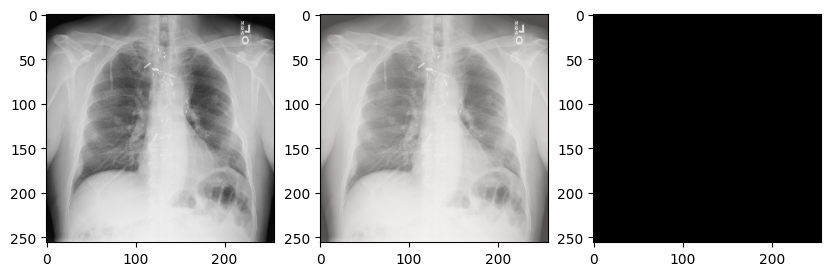

In [18]:
# Visualizing the first 20 images in the dataset
for image, mask, label in combined.values[:1]:
  plt.figure(figsize=(10, 6))
  image, mask = decode_image(image, mask)
  plt.subplot(131)
  plt.imshow(image, cmap = plt.cm.bone)
  plt.subplot(132)
  plt.imshow(image, cmap = plt.cm.bone)
  plt.imshow(np.squeeze(mask), alpha = 0.3, cmap = 'Reds')
  plt.subplot(133)
  plt.imshow(np.squeeze(mask), cmap = 'gray')
  plt.show()

In [19]:
pneumo = combined[combined['Label']== 1]
pneumo.head()

,path,mask,Label
1,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.136...,1
3,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.103...,1
4,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.100...,1
10,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.351...,1
13,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.140...,1


In [20]:
nonpneumo = combined[combined['Label'] == 0]
nonpneumo.head()

,path,mask,Label
0,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.690...,0
2,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.110...,0
5,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.114...,0
6,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.322...,0
7,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.323...,0


In [21]:
# Creating a data set with equal number of healthy and unhealthy images
reduced_non = nonpneumo.iloc[:1000]
balanced = pneumo.append(reduced_non, ignore_index = True).sample(frac = 1)
balanced.head()

<ipython-input-21-129e41dbfa5a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced = pneumo.append(reduced_non, ignore_index = True).sample(frac = 1)


,path,mask,Label
3450,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.115...,0
2461,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.311...,1
2901,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.325...,0
59,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.583...,1
2423,siim/train_images_dicom/1.2.276.0.7230010.3.1....,siim/masks/1.2.276.0.7230010.3.1.4.8323329.417...,1


In [22]:
ftrain, ftest = train_test_split(pneumo, test_size = 0.1,random_state = 27)
print(ftrain.shape)
print(ftest.shape)

(2402, 3)
(267, 3)


In [23]:
# Defining data generators for the training and validation data
# The validation data will not be shuffled or augmented
AUTOTUNE = tf.data.experimental.AUTOTUNE
def train_data_generator(images, masks,cache=True,cache_dir=""):
  if cache_dir != "" and cache is True:
    os.makedirs(cache_dir, exist_ok=True)
  dataset = tf.data.Dataset.from_tensor_slices((images, masks))
  dataset = dataset.shuffle(len(images), seed = 42)
  dataset = dataset.map(decode_image, num_parallel_calls = AUTOTUNE)
  dataset = dataset.cache(cache_dir) if cache else dataset
  dataset = dataset.map(augment, num_parallel_calls = AUTOTUNE)
  dataset = dataset.map(shape, num_parallel_calls = AUTOTUNE)
  return dataset

def val_data_generator(images, masks,cache=True,cache_dir=""):
  if cache_dir != "" and cache is True:
    os.makedirs(cache_dir, exist_ok=True)
  dataset = tf.data.Dataset.from_tensor_slices((images, masks))
  dataset = dataset.shuffle(len(images), seed = 42)
  dataset = dataset.map(decode_image, num_parallel_calls = AUTOTUNE)
  dataset = dataset.cache(cache_dir) if cache else dataset
  dataset = dataset.map(shape, num_parallel_calls = AUTOTUNE)
  return dataset

In [24]:
train_image_paths = ftrain['path'].values
train_mask_paths = ftrain['mask'].values
test_image_paths = ftest['path'].values
test_mask_paths = ftest['mask'].values

In [25]:
# Creating the generators
train_data = train_data_generator(train_image_paths, train_mask_paths,cache_dir='Kaggle2/tf_cache')
val_data = val_data_generator(test_image_paths, test_mask_paths,cache_dir='Kaggle2/tf_cache')

In [26]:
from datetime import datetime
import tensorboard

%load_ext tensorboard

optim = tf.keras.optimizers.Adam(0.0001)
BATCH_SIZE=16

In [27]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [29]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
metrics = ["accuracy",dice_coef]

input_shape = (256,256,3)

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    bachbone = ResNet50(weights=None, include_top=False, input_tensor=inputs)

    predictions = tf.keras.layers.Dense(14,activation='sigmoid', name='predictions')(bachbone.output)

    base_model2 = tf.keras.Model(inputs = bachbone.input, outputs = predictions)
    #Adding a pooling layer
    new_base_model = tf.keras.layers.GlobalAveragePooling2D()(base_model2.layers[-3].output)

    new_base_model = tf.keras.layers.Dense(1024, activation='relu')(new_base_model)
    new_base_model = tf.keras.layers.BatchNormalization()(new_base_model)
    new_base_model = tf.keras.layers.Dropout(0.4)(new_base_model)

    new_base_model = tf.keras.layers.Dense(512, activation='relu')(new_base_model)
    new_base_model = tf.keras.layers.BatchNormalization()(new_base_model)
    new_base_model = tf.keras.layers.Dropout(0.4)(new_base_model)

    new_base_model = tf.keras.layers.Dense(64, activation='relu')(new_base_model)

    #Adding the final Dense layer for prediction
    new_base_model = tf.keras.layers.Dense(1, activation='sigmoid')(new_base_model)

    base_model = tf.keras.Model(base_model2.input, new_base_model)
    base_model.load_weights("/content/drive/MyDrive/KhoaLuan/Phân Loại/save_models/ResNet50.h5")
    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model
model=DeepLabV3Plus(input_shape)
model.summary();

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [30]:
model.inputs, model.outputs

([<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>],
 [<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'activation_8')>])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss = bce_dice_loss , metrics = metrics)

In [31]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss = bce_dice_loss , metrics = metrics)
train_dataloader = train_data.batch(BATCH_SIZE, drop_remainder = True)
test_dataloader = val_data.batch(BATCH_SIZE, drop_remainder = True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/KhoaLuan/Phân Đoạn/save_models/Pre_traind_DeepLabV3.h5', save_weights_only=True, save_best_only=True,
                                       mode='min', monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.00001,patience=5)
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', baseline=None, restore_best_weights=False)
]

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=150, validation_data=test_dataloader, callbacks = callbacks)

Epoch 1/150
150/150 [==============================] - 755s 5s/step - loss: 0.8872 - accuracy: 0.9721 - dice_coef: 0.3848 - val_loss: 0.8995 - val_accuracy: 0.9896 - val_dice_coef: 0.4237 - lr: 1.0000e-04
Epoch 2/150
150/150 [==============================] - 23s 152ms/step - loss: 0.5951 - accuracy: 0.9898 - dice_coef: 0.5617 - val_loss: 0.7029 - val_accuracy: 0.9913 - val_dice_coef: 0.3777 - lr: 1.0000e-04
Epoch 3/150
150/150 [==============================] - 23s 154ms/step - loss: 0.4654 - accuracy: 0.9918 - dice_coef: 0.6360 - val_loss: 0.5770 - val_accuracy: 0.9917 - val_dice_coef: 0.4979 - lr: 1.0000e-04
Epoch 4/150
150/150 [==============================] - 22s 144ms/step - loss: 0.3854 - accuracy: 0.9931 - dice_coef: 0.6884 - val_loss: 0.5974 - val_accuracy: 0.9923 - val_dice_coef: 0.4606 - lr: 1.0000e-04
Epoch 5/150
150/150 [==============================] - 22s 143ms/step - loss: 0.3381 - accuracy: 0.9938 - dice_coef: 0.7211 - val_loss: 0.6094 - val_accuracy: 0.9909 - val_di

In [ ]:
def plot(r):

    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(r.history['dice_coef'], label='dice_coef')
    plt.plot(r.history['val_dice_coef'], label='val_dice_coef')
    plt.title('Dice_coef score Evolution')
    plt.legend()

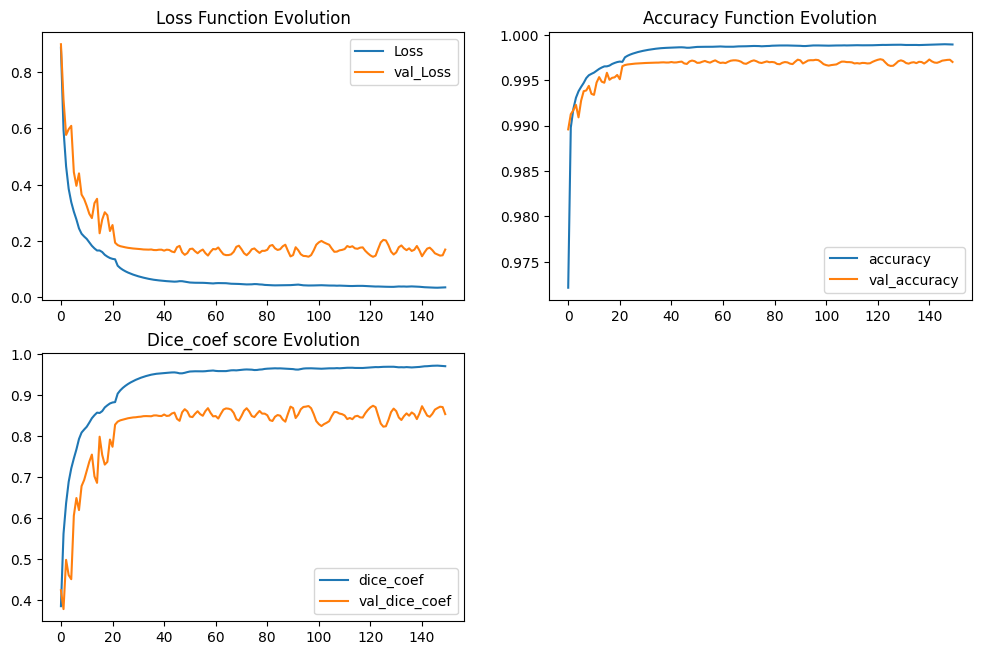

In [ ]:
plot(history)

In [ ]:
model.evaluate(test_dataloader, verbose=1)

16/16 [==============================] - 1s 49ms/step - loss: 0.1438 - accuracy: 0.9973 - dice_coef: 0.8741


[0.14381742477416992, 0.997326135635376, 0.8740661144256592]

In [32]:
model.load_weights('/content/drive/MyDrive/KhoaLuan/Phân Đoạn/save_models/Pre_traind_DeepLabV3.h5')

In [ ]:
ftrain.values[:3]

array([['siim/train_images_dicom/1.2.276.0.7230010.3.1.4.8323329.10854.1517875225.968980.dcm',
        'siim/masks/1.2.276.0.7230010.3.1.4.8323329.10854.1517875225.968980.dcm_mask.png',
        1],
       ['siim/train_images_dicom/1.2.276.0.7230010.3.1.4.8323329.6985.1517875202.229878.dcm',
        'siim/masks/1.2.276.0.7230010.3.1.4.8323329.6985.1517875202.229878.dcm_mask.png',
        1],
       ['siim/train_images_dicom/1.2.276.0.7230010.3.1.4.8323329.2595.1517875173.648438.dcm',
        'siim/masks/1.2.276.0.7230010.3.1.4.8323329.2595.1517875173.648438.dcm_mask.png',
        1]], dtype=object)

1/1 [==============================] - 8s 8s/step


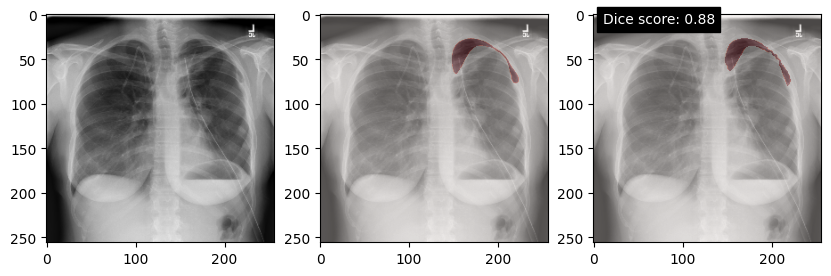

In [33]:
for image, mask, label in ftrain.values[:1]:
    # Original image
    image, image_mask = decode_image('siim/train_images_dicom/1.2.276.0.7230010.3.1.4.8323329.2595.1517875173.648438.dcm', 'siim/masks/1.2.276.0.7230010.3.1.4.8323329.2595.1517875173.648438.dcm_mask.png')
    # Predicted mask
    predicted  = model.predict(image[np.newaxis,:,:,:])
    # Removing unwanted dimensions
    predicted = predicted[0, :, :, 0]
    # Using a threshold of 0.57 for classifying a pixel as mask or non-mask
    predicted = predicted > 0.57
    predicted = predicted.astype(float)

    plt.figure(figsize=(10,6))
    # Original image
    plt.subplot(131)
    plt.imshow(image, cmap = plt.cm.bone)
    plt.subplot(132)
    # Image with original mask
    plt.imshow(image, cmap = plt.cm.bone)
    plt.imshow(np.squeeze(image_mask), alpha = 0.3, cmap = 'Reds')
    plt.subplot(133)
    # Image with predicted mask
    plt.imshow(image, cmap = plt.cm.bone)
    plt.imshow(predicted, alpha = 0.3, cmap = "Reds")
    # Calculate dice score
    dice_score = dice_coef(image_mask, predicted)

    # Add dice score text to the image
    plt.text(10, 10, f"Dice score: {dice_score:.2f}", color='white', backgroundcolor='black')
    plt.show()

1/1 [==============================] - 0s 27ms/step


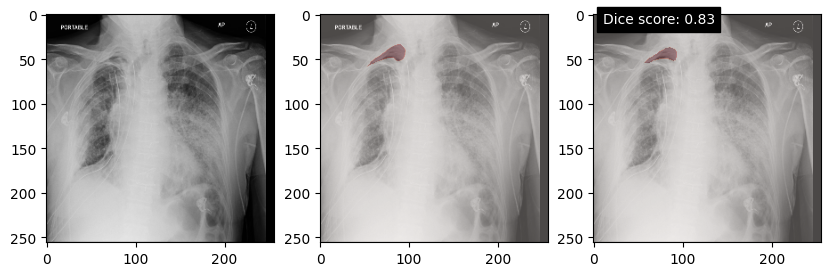

In [34]:
for image, mask, label in ftrain.values[:1]:
    # Original image
    image, image_mask = decode_image('siim/train_images_dicom/1.2.276.0.7230010.3.1.4.8323329.1328.1517875167.265504.dcm', 'siim/masks/1.2.276.0.7230010.3.1.4.8323329.1328.1517875167.265504.dcm_mask.png')
    # Predicted mask
    predicted  = model.predict(image[np.newaxis,:,:,:])
    # Removing unwanted dimensions
    predicted = predicted[0, :, :, 0]
    # Using a threshold of 0.57 for classifying a pixel as mask or non-mask
    predicted = predicted > 0.57
    predicted = predicted.astype(float)

    plt.figure(figsize=(10,6))
    # Original image
    plt.subplot(131)
    plt.imshow(image, cmap = plt.cm.bone)
    plt.subplot(132)
    # Image with original mask
    plt.imshow(image, cmap = plt.cm.bone)
    plt.imshow(np.squeeze(image_mask), alpha = 0.3, cmap = 'Reds')
    plt.subplot(133)
    # Image with predicted mask
    plt.imshow(image, cmap = plt.cm.bone)
    plt.imshow(predicted, alpha = 0.3, cmap = "Reds")
    # Calculate dice score
    dice_score = dice_coef(image_mask, predicted)

    # Add dice score text to the image
    plt.text(10, 10, f"Dice score: {dice_score:.2f}", color='white', backgroundcolor='black')
    plt.show()

1/1 [==============================] - 0s 29ms/step


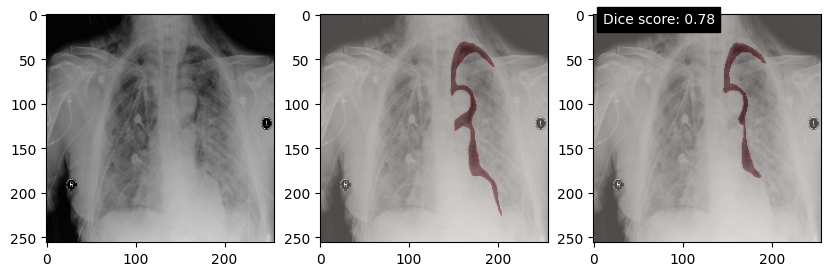

In [35]:
for image, mask, label in ftrain.values[:1]:
    # Original image
    image, image_mask = decode_image('siim/train_images_dicom/1.2.276.0.7230010.3.1.4.8323329.1246.1517875166.960329.dcm', 'siim/masks/1.2.276.0.7230010.3.1.4.8323329.1246.1517875166.960329.dcm_mask.png')
    # Predicted mask
    predicted  = model.predict(image[np.newaxis,:,:,:])
    # Removing unwanted dimensions
    predicted = predicted[0, :, :, 0]
    # Using a threshold of 0.57 for classifying a pixel as mask or non-mask
    predicted = predicted > 0.57
    predicted = predicted.astype(float)

    plt.figure(figsize=(10,6))
    # Original image
    plt.subplot(131)
    plt.imshow(image, cmap = plt.cm.bone)
    plt.subplot(132)
    # Image with original mask
    plt.imshow(image, cmap = plt.cm.bone)
    plt.imshow(np.squeeze(image_mask), alpha = 0.3, cmap = 'Reds')
    plt.subplot(133)
    # Image with predicted mask
    plt.imshow(image, cmap = plt.cm.bone)
    plt.imshow(predicted, alpha = 0.3, cmap = "Reds")
    # Calculate dice score
    dice_score = dice_coef(image_mask, predicted)

    # Add dice score text to the image
    plt.text(10, 10, f"Dice score: {dice_score:.2f}", color='white', backgroundcolor='black')
    plt.show()